In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn
import pickle as pkl 

from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

%matplotlib inline

# Data Exploration

In this notebook, we want to first explore our heartbeat data, then train, validate, and test a number of machine learning techniques in order to identify outliers in the data. This problem is effectively the same as binary classification. Our input is a hearbeat pattern and the output is either a 0 for `not an outlier` or 1 for `outlier`. 

In [46]:
with open('data/train_data.pkl', "rb") as input_file:
    train_data = pkl.load(input_file)

In [47]:
len(train_data['train_x'])

349

In [48]:
type(train_data['train_y'][0])

bool

In [49]:
type(train_data['train_x'])

list

It looks like our data is a dictionary with keys `train_x` and `train_y`. `train_x` contains a list of 349 heartbeat traces and `train_y` are the labels for each heartbeat, so either true for good heartbeats and false for bad heartbeats. Each of the elements of the list contain a 1000 element 1d numpy array. 

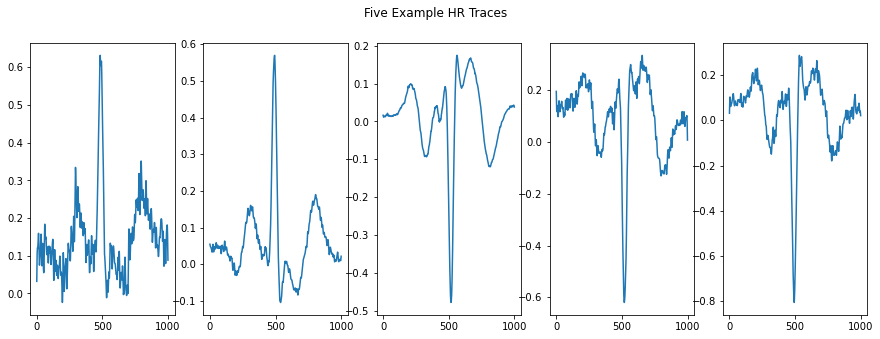

In [50]:
plotting_x = np.arange(1000)
num_plots = 5
fig, axs = plt.subplots(1, num_plots, figsize = (15,5))
fig.suptitle('Five Example HR Traces')
for plot in range(num_plots):
    axs[plot].plot(plotting_x, train_data['train_x'][plot])

Interesting, we can visually see some differences already. Let's take a look at the labels for these first five traces. 

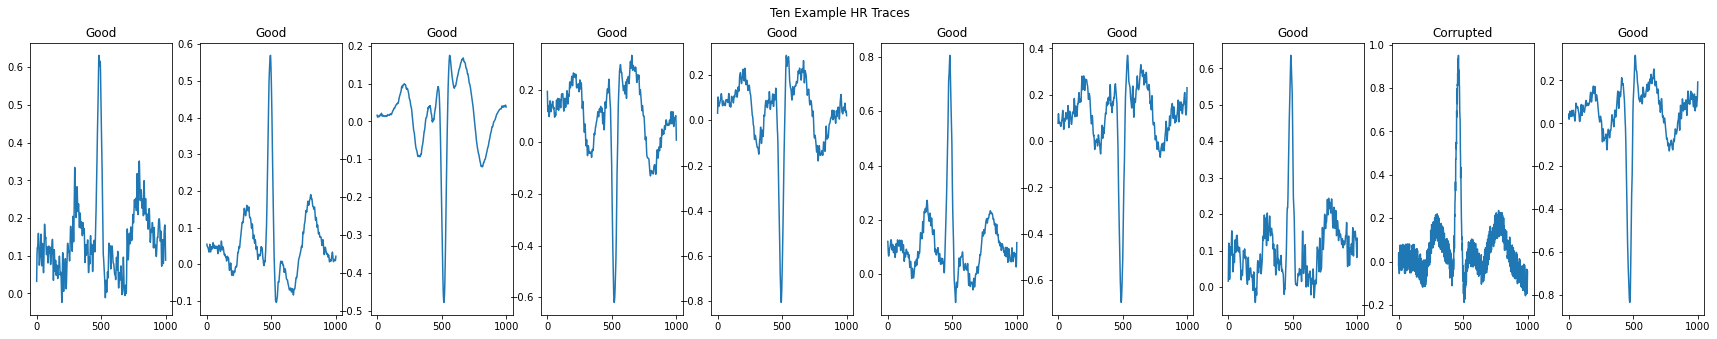

In [51]:
plotting_x = np.arange(1000)
num_plots = 10
fig, axs = plt.subplots(1, num_plots, figsize = (30,5))
fig.suptitle('Ten Example HR Traces')
for plot in range(num_plots):
    axs[plot].plot(plotting_x, train_data['train_x'][plot])
    title = 'Good' if train_data['train_y'][plot] else 'Corrupted'
    axs[plot].title.set_text(title)
    


Interesting, it looks like the differences we were seeing before were normal differences. The 9th item here is the only corrupted heart rate trace that we see. Visually, it looks more noisy, but we'll need more than just that to try and predict this. 

## Classes

Let's try and figure out how much data in each class we have. It could be a problem if our corrupted data is far too small. 

In [52]:
train_data['train_y'] = np.array(train_data['train_y'])

In [53]:
noncorrupted_count = np.count_nonzero(train_data['train_y']) # Number of noncorrupted items
noncorrupted_count

295

In [54]:
corrupted_count = train_data['train_y'].size - noncorrupted_count

Text(0.5, 1.0, 'Class Data Imbalance')

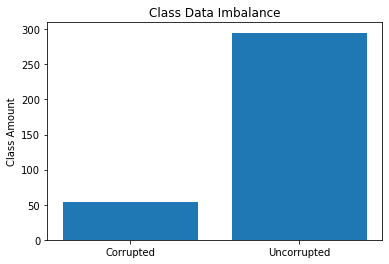

In [55]:
plt.bar(['Corrupted', 'Uncorrupted'],[corrupted_count, noncorrupted_count])
plt.ylabel('Class Amount')
plt.title('Class Data Imbalance')

Yikes, it looks like we have nearly 6 times as much noncorrupted data as corrupted data. This was mildly expected, but it's a problem we'll have to deal with later on. For now, let's start simple and see how we do. 

# Analysis

Since our dataset is quite limited we'll be using `k-fold cross-validation` in lieu of a standard train test split. Let's start with `k=10`. 

In [56]:
kfold = KFold(10, shuffle = True,random_state =  1)
indices = np.arange(len(train_data['train_x']))

In [57]:
for train, test in kfold.split(indices): 
    print('train: %s, test: %s' % (len(train), len(test)))

train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 314, test: 35
train: 315, test: 34


## Linear Classifier

Let's start with a linear classifier. This is equivalent to a perceptron, so let's just implement a perceptron in pytorch. 

### Let's start with our hyperparameters. 

This will be the number of epochs - number of times we iterate over our dataset, batch size, and learning rate. 

In [58]:
epochs = 50
batch_size = 64 
learning_rate = .001

In [59]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    



In [60]:
class Perceptron(nn.Module):
    def __init__(self, input_size = 1000):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    def forward(self, inputs):
        return self.linear(inputs)
    

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = Perceptron()
model.to(device)
print(model)

cuda:0
Perceptron(
  (linear): Linear(in_features=1000, out_features=1, bias=True)
)


In [62]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [64]:
model.train()

for train, test in kfold.split(indices): 
    print()
    X_train = np.copy(np.array(train_data['train_x'])[train])
    y_train = np.copy(np.array(train_data['train_y'])[train])
    X_test = np.copy(np.array(train_data['train_x'])[test])
    y_test = np.copy(np.array(train_data['train_y'])[test])
    traindata = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    testdata = testData(torch.FloatTensor(X_test))
    train_loader = DataLoader(dataset=traindata, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=testdata, batch_size=1)
    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()


        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')


Epoch 001: | Loss: 0.66127 | Acc: 74.600
Epoch 002: | Loss: 0.62909 | Acc: 83.200
Epoch 003: | Loss: 0.62510 | Acc: 83.800
Epoch 004: | Loss: 0.61734 | Acc: 83.800
Epoch 005: | Loss: 0.60999 | Acc: 82.600
Epoch 006: | Loss: 0.60191 | Acc: 82.600
Epoch 007: | Loss: 0.59720 | Acc: 82.200
Epoch 008: | Loss: 0.59110 | Acc: 82.600
Epoch 009: | Loss: 0.58485 | Acc: 81.800
Epoch 010: | Loss: 0.57848 | Acc: 82.000
Epoch 011: | Loss: 0.57450 | Acc: 82.200
Epoch 012: | Loss: 0.56934 | Acc: 83.000
Epoch 013: | Loss: 0.56449 | Acc: 82.600
Epoch 014: | Loss: 0.56008 | Acc: 82.600
Epoch 015: | Loss: 0.55523 | Acc: 83.000
Epoch 016: | Loss: 0.54921 | Acc: 83.000
Epoch 017: | Loss: 0.54494 | Acc: 83.800
Epoch 018: | Loss: 0.54164 | Acc: 84.000
Epoch 019: | Loss: 0.53894 | Acc: 84.400
Epoch 020: | Loss: 0.53366 | Acc: 84.200
Epoch 021: | Loss: 0.53059 | Acc: 84.600
Epoch 022: | Loss: 0.52974 | Acc: 84.200
Epoch 023: | Loss: 0.52268 | Acc: 84.200
Epoch 024: | Loss: 0.51883 | Acc: 85.000
Epoch 025: | Lo

Epoch 014: | Loss: 0.27260 | Acc: 94.600
Epoch 015: | Loss: 0.27179 | Acc: 94.800
Epoch 016: | Loss: 0.27105 | Acc: 95.400
Epoch 017: | Loss: 0.27102 | Acc: 95.200
Epoch 018: | Loss: 0.27165 | Acc: 95.000
Epoch 019: | Loss: 0.26937 | Acc: 95.200
Epoch 020: | Loss: 0.26869 | Acc: 95.200
Epoch 021: | Loss: 0.26828 | Acc: 95.200
Epoch 022: | Loss: 0.26659 | Acc: 95.200
Epoch 023: | Loss: 0.26592 | Acc: 95.200
Epoch 024: | Loss: 0.26497 | Acc: 95.200
Epoch 025: | Loss: 0.26779 | Acc: 95.000
Epoch 026: | Loss: 0.26380 | Acc: 95.000
Epoch 027: | Loss: 0.26190 | Acc: 95.200
Epoch 028: | Loss: 0.26175 | Acc: 95.400
Epoch 029: | Loss: 0.26083 | Acc: 95.200
Epoch 030: | Loss: 0.26135 | Acc: 95.400
Epoch 031: | Loss: 0.25873 | Acc: 95.400
Epoch 032: | Loss: 0.25899 | Acc: 95.400
Epoch 033: | Loss: 0.25892 | Acc: 95.200
Epoch 034: | Loss: 0.25928 | Acc: 95.000
Epoch 035: | Loss: 0.25726 | Acc: 95.200
Epoch 036: | Loss: 0.25742 | Acc: 95.400
Epoch 037: | Loss: 0.25611 | Acc: 95.200
Epoch 038: | Los

Epoch 019: | Loss: 0.17630 | Acc: 97.600
Epoch 020: | Loss: 0.17460 | Acc: 97.600
Epoch 021: | Loss: 0.17503 | Acc: 97.600
Epoch 022: | Loss: 0.17493 | Acc: 97.600
Epoch 023: | Loss: 0.17452 | Acc: 97.800
Epoch 024: | Loss: 0.17305 | Acc: 97.800
Epoch 025: | Loss: 0.17314 | Acc: 97.600
Epoch 026: | Loss: 0.17318 | Acc: 97.800
Epoch 027: | Loss: 0.17301 | Acc: 97.600
Epoch 028: | Loss: 0.17154 | Acc: 97.600
Epoch 029: | Loss: 0.17157 | Acc: 97.600
Epoch 030: | Loss: 0.17135 | Acc: 97.600
Epoch 031: | Loss: 0.17096 | Acc: 97.800
Epoch 032: | Loss: 0.17079 | Acc: 97.600
Epoch 033: | Loss: 0.16934 | Acc: 97.800
Epoch 034: | Loss: 0.16975 | Acc: 97.600
Epoch 035: | Loss: 0.16896 | Acc: 97.600
Epoch 036: | Loss: 0.16770 | Acc: 97.600
Epoch 037: | Loss: 0.16873 | Acc: 97.400
Epoch 038: | Loss: 0.16900 | Acc: 97.600
Epoch 039: | Loss: 0.16761 | Acc: 97.600
Epoch 040: | Loss: 0.16683 | Acc: 97.600
Epoch 041: | Loss: 0.16640 | Acc: 97.600
Epoch 042: | Loss: 0.16640 | Acc: 97.800
Epoch 043: | Los

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4320938/

https://arxiv.org/pdf/1901.09972.pdf

In [43]:
train_data

IndexError: too many indices for tensor of dimension 2